# MSC Geomet - Example with Authentication to Access Flow Predictions

This notebook provides examples of how to use user/password authentication on Meteorological Service of Canada's (MSC) [Geomet](https://eccc-msc.github.io/open-data/msc-geomet/readme_en/#msc-geomet "MSC Geomet Open Documentation") platform, in order to access flow prediction through both the web map service (WMS) and web coverage service (WCS) with Python. 

## Requirements

First, we import all necessary Python libraries.  Some of these are standard Python libraries, while others are third-party libraries that must first be installed in your Python environment, namely [OWSLib](https://geopython.github.io/OWSLib/index.html "OWSLib Documentation"), which stands for the Open Geospatial Consortium (OGC) web service and which we'll use for accessing the Geomet WMS and WCS, and also [xarray](https://docs.xarray.dev/en/stable/ "xarray Documentation"), which we'll use to read the data, plus some plotting libraries to let us look at it.

In [56]:
# data
import warnings
import re
import time
import configparser
from datetime import datetime, timedelta
import xarray as xr

# web map services 
from owslib.wms import WebMapService
from owslib.wcs import WebCoverageService
from owslib.wcs import Authentication

# plotting
from IPython.display import Image
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
# import hvplot.xarray 
# this is a great library, but I've found it can be tough to install owing to conflicts in my environment, so left out here
# if you have it installed, have at it.

To access the flow prediction from the user/password authenticated version of Geomet, we need credentials.  I used the built-in configparser utility library, which reads a file with the following format:

[Login]
Username = your_user_name
Password = your_password

In [57]:
config = configparser.ConfigParser()
config.read_file(open('config.cfg'))

login = config['Login']

# Web Map Service Examples

The Geomet WMS provides access to georeferenced map images, also known as raster images or tiles. These display hydro-meteorological variables from multiple MSC monitoring and numerical modelling systems and their related products.  Included with the map images is descriptive information, i.e., metadata, that includes attributes describing each of the different map images and how they should be displayed.  Together, the descriptive information and images are called layers. 

We can connect to the WMS using OWSlib.  The typical way to do this without authentication is as follows:

In [58]:
# filter warnings or prepared to see plenty
warnings.filterwarnings('ignore', module='owslib', category=UserWarning)

# connect to web service
wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS',
                    version='1.3.0',
                    timeout=300)

In [59]:
# Some wms metadata
print(wms.url)
print(wms.version)
print(wms.provider.name)
print(wms.provider.url)
# some additional metadata re: GeoMet
print(wms.identification.title)
print(wms.identification.abstract)

https://geo.weather.gc.ca/geomet
1.3.0
Government of Canada, Environment and Climate Change Canada, Meteorological Service of Canada
https://eccc-msc.github.io/open-data/msc-geomet/readme_en/
MSC GeoMet — GeoMet-Weather 2.18.2
GeoMet-Weather provides public access to the Meteorological Service of Canada (MSC) and Environment and Climate Change Canada (ECCC) data via interoperable web services and application programming interfaces (API). Through open standards, users can freely and quickly access thousands of real-time and archived weather, climate and water datasets and products and integrate them in their domain-specific applications and decision support systems. Users can build mobile apps, create interactive web maps, and display and animate MSC data in desktop software. MSC GeoMet also enables on demand raw data clipping and reprojection, on demand format conversion and custom visualization.


In [60]:
# check operations available from the wms
for op in wms.operations:
    print(op.name, op.formatOptions) # op.methods

GetCapabilities ['text/xml']
GetMap ['image/png', 'image/jpeg']
GetFeatureInfo ['text/plain', 'application/json', 'application/vnd.ogc.gml']
DescribeLayer ['text/xml']
GetLegendGraphic ['image/png', 'image/jpeg', 'image/png; mode=8bit', 'image/vnd.jpeg-png', 'image/vnd.jpeg-png8']
GetStyles ['text/xml']


In [61]:
# check the first 20 contents within it
print(len(wms.contents))
for key in list(wms.contents.keys())[0:20]:
    print(key)

3621
Canadian Weather
ALERTS
CURRENT_CONDITIONS
METNOTES
Regional Deterministic Prediction System (RDPS) [10 km]
RDPS - Coupled to Gulf of St. Lawrence (RDPS-CGSL)
CGSL.ETA_ICEC
CGSL.ETA_ICEPRS
CGSL.ETA_ICESTG
CGSL.ETA_ICET
CGSL.ETA_ICETK
CGSL.ETA_UICE
CGSL.ETA_UOGRD
CGSL.ETA_UU
CGSL.ETA_WTMP
RDPS convective fields
RDPS.CONV_KINDEX.PT3H
RDPS.CONV_ML-CAPE
RDPS.CONV_ML-CIN
RDPS.CONV_ML-EL-HGT


In [62]:
# look for WCPS, flows are not included
for key in list(wms.contents.keys()):
    if "WCPS" in key:
        print(key)

Water Cycle Prediction System (WCPS) [1 km]
WCPS.2D_GE
WCPS.2D_GL
WCPS.2D_MLW
WCPS.2D_SALW
WCPS.2D_SIII
WCPS.2D_SSH
WCPS.2D_STGI
WCPS.2D_TM2
WCPS.2D_TT
WCPS.2D_UU
WCPS.2D_UU2W
WCPS.2D_UUI


In [63]:
# layer details
wms['WCPS.2D_TT'].title
wms['WCPS.2D_TT'].queryable
wms['WCPS.2D_TT'].boundingBox
wms['WCPS.2D_TT'].crsOptions
wms['WCPS.2D_TT'].opaque

0

In [64]:
# look for DHPS or EHPS, nothing returned
for key in list(wms.contents.keys()):
    if "DHPS" in key or "EHPS" in key:
        print(key)

The reason why is that the layers are not just password-protected, they are completely hidden.

To connect to the authenticated version of WMS, we do one of the following:

In [65]:
# pass the layer name to the request
layer_name = 'DHPS_1km_RiverDischarge'

# use username and password parameters individually
wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
                    version='1.3.0',
                    username=login['Username'],
                    password=login['Password'],
                    timeout=300)

for key in list(wms.contents.keys()):
    print(key)

Deterministic Hydrological Prediction System (DHPS) [1 km]
DHPS
DHPS_1km_RiverDischarge


In [66]:
# use auth parameter with Authentication utility
wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
                    version='1.3.0',
                    auth=Authentication(username=login['Username'], password=login['Password']),
                    timeout=300)

for key in list(wms.contents.keys()):
    print(key)

Deterministic Hydrological Prediction System (DHPS) [1 km]
DHPS
DHPS_1km_RiverDischarge


The second approach with `auth = Authentication(username, password)` is preferable since only it will work with the WebCoverageService request later on and to be consistent.

Note again all layers are hidden.  You can see that by connecting to the WMS and providing authentication, but no layer information:

In [67]:
# use auth parameter with Authentication utility
wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE',
                    version='1.3.0',
                    auth=Authentication(username=login['Username'], password=login['Password']),
                    timeout=300)

# looking for WCPS, DHPS or EHPS, still no flow predictions are returned
for key in list(wms.contents.keys()):
    if "WCPS" in key or "DHPS" in key or "EHPS" in key:
        print(key)

Water Cycle Prediction System (WCPS) [1 km]
WCPS.2D_GE
WCPS.2D_GL
WCPS.2D_MLW
WCPS.2D_SALW
WCPS.2D_SIII
WCPS.2D_SSH
WCPS.2D_STGI
WCPS.2D_TM2
WCPS.2D_TT
WCPS.2D_UU
WCPS.2D_UU2W
WCPS.2D_UUI


<div class="alert alert-block alert-warning">
<b>So to use the authenticated version of Geomet, whether WMS or WCS, you have to provide the layer name as well as the authentication information, which means you need to know the layer name you're looking for in advance of the request.
</div>

Luckily, here's a list of layers:

In [68]:
# DHPS_1km_CorrectedFlowDir
# DHPS_1km_DeepReservoirStorage_PT24H
# DHPS_1km_DrainageArea
# DHPS_1km_Evap-SpatialAvg12h_PT12H
# DHPS_1km_Precip-SpatialAvg12h_PT12H
# DHPS_1km_RiverChannelStorage_PT24H
# DHPS_1km_RiverDischarge
# DHPS_1km_TotalRunoff-Avg12h_PT12H
# DHPS_1km_WaterbodyID
# DHPS-Analysis_1km_RiverDischarge
# DHPS-Analysis_1km_DeepReservoirStorage
# DHPS-Analysis_1km_Evap-SpatialAvg12h
# DHPS-Analysis_1km_Precip-SpatialAvg12h
# DHPS-Analysis_1km_RiverChannelStorage
# DHPS-Analysis_1km_TotalRunoff-Avg12h

# EHPS_1km_CorrectedFlowDir
# EHPS_1km_DrainageArea
# EHPS_1km_WaterbodyID
# EHPS_1km_RiverDischarge_Mem01
# EHPS_1km_RiverDischarge_Mem..
# EHPS_1km_RiverDischarge_Mem21
# EHPS_1km_DeepReservoirStorage_PT24H_Mem01
# EHPS_1km_DeepReservoirStorage_PT24H_Mem..
# EHPS_1km_DeepReservoirStorage_PT24H_Mem21
# EHPS_1km_RiverChannelStorage_PT24H_Mem01
# EHPS_1km_RiverChannelStorage_PT24H_Mem..
# EHPS_1km_RiverChannelStorage_PT24H_Mem21
# EHPS_1km_Evap-SpatialAvg12h_PT12H_Mem01
# EHPS_1km_Evap-SpatialAvg12h_PT12H_Mem..
# EHPS_1km_Evap-SpatialAvg12h_PT12H_Mem21
# EHPS_1km_Precip-SpatialAvg12h_PT12H_Mem01
# EHPS_1km_Precip-SpatialAvg12h_PT12H_Mem..
# EHPS_1km_Precip-SpatialAvg12h_PT12H_Mem21
# EHPS_1km_TotalRunoff-Avg12h_PT12H_Mem01
# EHPS_1km_TotalRunoff-Avg12h_PT12H_Mem..
# EHPS_1km_TotalRunoff-Avg12h_PT12H_Mem21
# EHPS-Analysis_1km_RiverDischarge
# EHPS-Analysis_1km_DeepReservoirStorage
# EHPS-Analysis_1km_Evap-SpatialAvg12h
# EHPS-Analysis_1km_Precip-SpatialAvg12h
# EHPS-Analysis_1km_RiverChannelStorage
# EHPS-Analysis_1km_TotalRunoff-Avg12h

## Viewing

In [69]:
wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
                    version='1.3.0',
                    auth=Authentication(username=login['Username'], password=login['Password']),
                    timeout=300)

The DHPS flow prediction layers have been given multiple styles in order to deal with the wide range in magnitude of flows across Canada

In [71]:
wms[layer_name].styles
wms[layer_name].dimensions['time']['values'][0] # time available from wms but not wcs?

'2022-04-21T01:00:00Z/2022-04-27T00:00:00Z/PT1H'

Let's check them out!

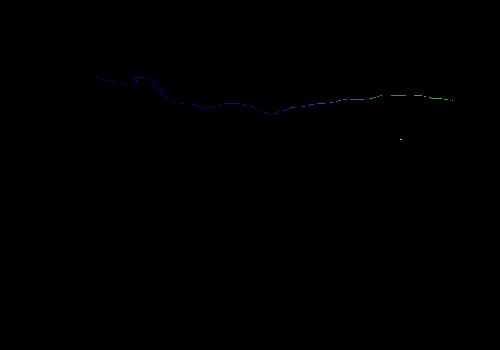

In [14]:
width = 500
height = 350

# example of how to get a map with specific extent covering eastern Ontario / southern Quebec
response = wms.getmap(layers=[layer_name],
                      format='image/jpeg',
                      srs='EPSG:4326',
                      bbox=(-78, 42, -74, 47),
                      size=(width, height),
                      transparent=True)

# show image
Image(response.read(), width=width, height=height)  # exciting!

In [15]:
response.geturl()

'https://geo.weather.gc.ca/geomet?service=WMS&version=1.3.0&request=GetMap&layers=DHPS_1km_RiverDischarge&styles=&width=500&height=350&crs=EPSG:4326&bbox=42,-78,47,-74&format=image/jpeg&transparent=TRUE&bgcolor=0xFFFFFF&exceptions=XML'

First tip, you need to indicate the style you want in the getmap request.  

What's strange is that it seems to default to RiverDischarge_XL, which is not the default.

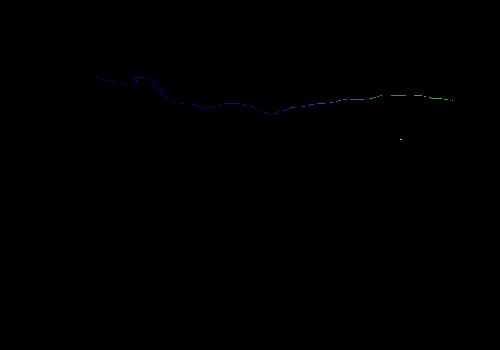

In [16]:
width = 500
height = 350

# example of how to get a map with specific extent covering eastern Ontario / southern Quebec
response = wms.getmap(layers=[layer_name],
                      format='image/jpeg',
                      srs='EPSG:4326',
                      styles=['RiverDischarge_XL'], # this only shows large rivers
                      bbox=(-78, 42, -74, 47),
                      size=(width, height),
                      transparent=True)

# show image
Image(response.read(), width=width, height=height)  # still not exciting!

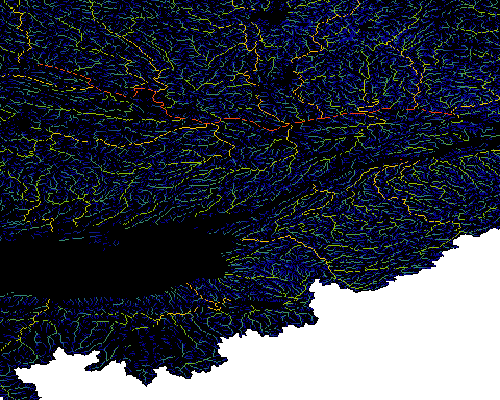

In [17]:
width = 500
height = 400

# example of how to get a map with specific extent covering eastern Ontario / southern Quebec
response = wms.getmap(layers=[layer_name],
                      format='image/png',
                      srs='EPSG:4326',
                      styles=['RiverDischarge'],  # this is supposed to be the default
                      bbox=(-78, 42, -74, 47),
                      size=(width, height),
                      transparent=True)

# show image
Image(response.read(), width=width, height=height)  # better!

## Matplotlib / Cartopy

Text(0.5, 1.0, 'WMS example - Layer : DHPS_1km_RiverDischarge')

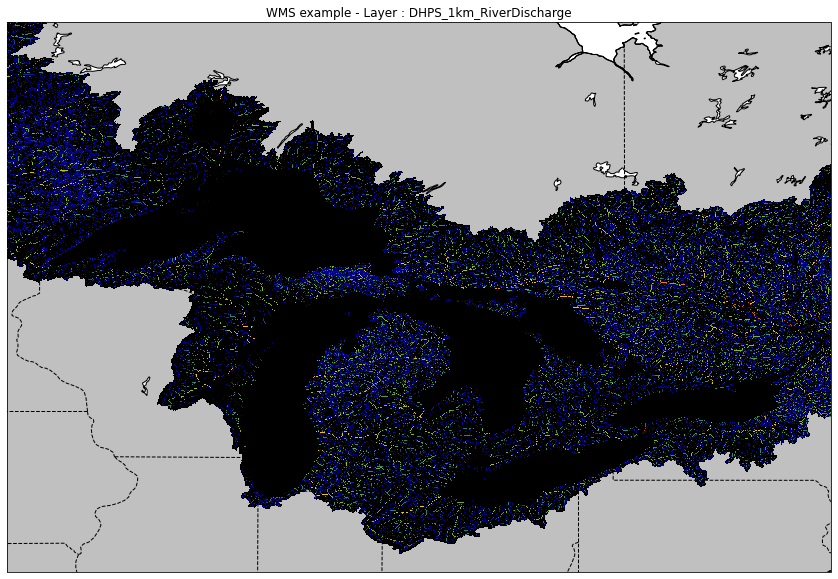

In [18]:
layer_name = 'DHPS_1km_RiverDischarge'
wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
                    version='1.3.0',
                    auth=Authentication(username=login['Username'], password=login['Password']),
                    timeout=300)

fig = plt.figure(figsize=(12,10))
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)

ax.set_extent([-93, -75, 40, 52])

fig.tight_layout(pad=2)

# features
edgecolor = 'black'

# Cartopy features 
ax.add_feature(cf.LAND, facecolor='silver', edgecolor=edgecolor)
ax.add_feature(cf.COASTLINE, edgecolor=edgecolor)
ax.add_feature(cf.LAKES, facecolor="white", edgecolor=edgecolor)

# Natural Earth Features
countries = cf.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries_lakes',
        scale='10m',
        edgecolor=edgecolor,
        facecolor='none')
borders = cf.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        edgecolor=edgecolor,
        facecolor='none')

ax.add_feature(countries)
ax.add_feature(borders, linestyle='dashed')

ax.add_wms(wms=wms, 
           layers=[layer_name], 
           wms_kwargs = {'transparent' : True, 'styles' : ['RiverDischarge']}, 
           zorder=10)

ax.set_title(f'WMS example - Layer : {layer_name}')

# Web Coverage Service Examples

In [28]:
# connect using auth / Authentication method 
# (note that username and password parameters individually are not accepted by WebCoverageService)
layer_name = 'DHPS_1km_RiverDischarge'

wcs = WebCoverageService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WCS&COVERAGEID={layer_name}', 
                    auth=Authentication(username=login['Username'], password=login['Password']),
                    version='2.0.1',
                    timeout=300
                    )

In [29]:
for key in list(wcs.contents.keys()):
    if "DHPS" in key:
        print(key)

DHPS_1km_RiverDischarge


In [30]:
vars(wcs.contents[layer_name])

{'_elem': <Element {http://www.opengis.net/wcs/2.0}CoverageSummary at 0x2014beec680>,
 '_service': <owslib.coverage.wcs201.WebCoverageService_2_0_1 at 0x2013b830f40>,
 'id': 'DHPS_1km_RiverDischarge',
 'title': None,
 'abstract': None,
 'keywords': [],
 'boundingBox': None,
 'boundingBoxWGS84': None,
 'styles': None,
 'crsOptions': None,
 'defaulttimeposition': None}

In [51]:
wcs[layer_name].dimensions['time']['values'][0]

AttributeError: 'ContentMetadata' object has no attribute 'dimensions'

In [80]:
response = wcs.getCoverage(identifier = [layer_name], 
                    format = 'image/netcdf', 
                    subsettingcrs = 'EPSG:4326', 
                    subsets = [('lat', 45.0, 58.0), ('lon', -70.0, -52.0)],
                    dim_reference_time='2022-04-21T01:00:00Z' # why doesn't this work?
                   )

ServiceException: Date et heure manquantes / Missing time parameter

In [81]:
response = wcs.getCoverage(identifier = [layer_name], 
                    format = 'image/netcdf', 
                    subsettingcrs = 'EPSG:4326', 
                    subsets = [('lat', 45.0, 58.0), ('lon', -70.0, -52.0)],
                    time='2022-04-21T01:00:00Z' # no error, but time not recognized in the query
                   )

In [78]:
response.info()

{'Date': 'Thu, 21 Apr 2022 17:39:19 GMT', 'Server': 'Apache', 'Strict-Transport-Security': 'max-age=63072000; preload', 'Content-Disposition': 'attachment; filename="geomet-weather_DHPS_1km_RiverDischarge_2022-04-21T0000Z_PT17H.nc"', 'Access-Control-Allow-Origin': '*', 'Access-Control-Allow-Headers': 'Origin, X-Requested-With, Content-Type, Accept, Authorization', 'Access-Control-Allow-Methods': 'POST, GET, OPTIONS', 'Content-Type': 'image/netcdf', 'Keep-Alive': 'timeout=5, max=100', 'Connection': 'Keep-Alive', 'Transfer-Encoding': 'chunked'}

In [79]:
# returns a url, but will prompt for username and password
# note the lack of time info
response.geturl()

'https://geo.weather.gc.ca/geomet?version=2.0.1&request=GetCoverage&service=WCS&CoverageID=DHPS_1km_RiverDischarge&format=image/netcdf&subsettingcrs=EPSG:4326&subset=lat(45.0,58.0)&subset=lon(-70.0,-52.0)'

In [84]:
response = wcs.getCoverage(identifier = [layer_name], 
                    format = 'image/netcdf', 
                    subsettingcrs = 'EPSG:4326', 
                    subsets = [('lat', 45.0, 58.0), ('lon', -70.0, -52.0)],
                    TIME='2022-04-21T01:00:00Z' # capitalization works???
                   )

In [85]:
# returns a url, but will prompt for username and password
# now we have the time info
response.geturl()

'https://geo.weather.gc.ca/geomet?version=2.0.1&request=GetCoverage&service=WCS&CoverageID=DHPS_1km_RiverDischarge&format=image/netcdf&subsettingcrs=EPSG:4326&TIME=2022-04-21T01:00:00Z&subset=lat(45.0,58.0)&subset=lon(-70.0,-52.0)'

In [86]:
# read into an xarray
ds = xr.open_dataset(response.read()).load()
ds

<xarray.Dataset>
Dimensions:  (lat: 1560, lon: 2100)
Coordinates:
  * lat      (lat) float64 45.0 45.01 45.02 45.03 ... 57.97 57.98 57.99 58.0
  * lon      (lon) float64 -70.0 -69.99 -69.98 -69.97 ... -52.52 -52.51 -52.5
Data variables:
    Band1    (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    GDAL_TIFFTAG_RESOLUTIONUNIT:  2
    GDAL_TIFFTAG_XRESOLUTION:     72.0
    GDAL_TIFFTAG_YRESOLUTION:     72.0
    Conventions:                  CF-1.5
    GDAL:                         GDAL 3.1.3, released 2020/09/01
    history:                      Thu Apr 21 17:46:12 2022: GDAL CreateCopy( ...

<div class="alert alert-block alert-warning">
<b>!! Why is there no time dimension?
</div>

In [71]:
# hvplot can be used to show an interactive map of the xarray, uncomment if installed
# ds.hvplot() 

Text(0.5, 1.0, 'WMS example - Layer : DHPS_1km_RiverDischarge')

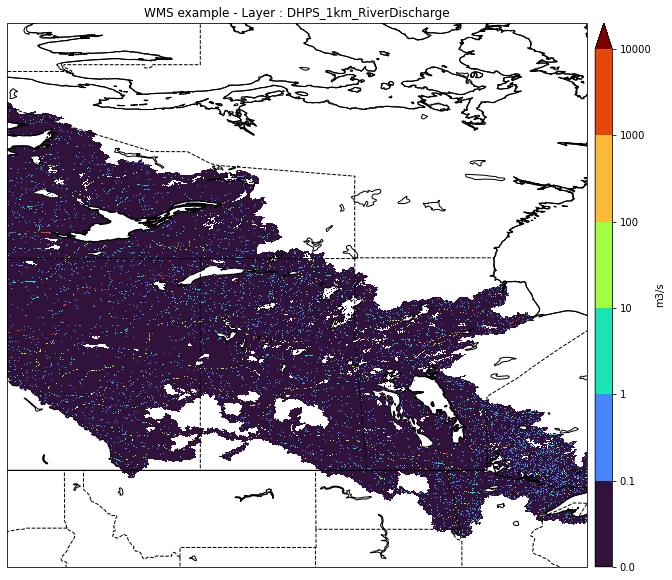

In [73]:
# The Prairies
north = 72
south = 44
east = -90
west = -120
response = wcs.getCoverage(identifier = [layer_name], 
                    format = 'image/netcdf', 
                    subsettingcrs = 'EPSG:4326', 
                    subsets = [('lat', south, north), ('lon', west, east)]
                   )
ds = xr.open_dataset(response.read()).load()

fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection=ccrs.PlateCarree(-70))
ax.set_extent([west, east, south, north])

levels = [0.01, 0.1, 1, 10, 100, 1000, 10000]
ticks = levels.copy()
cmap = plt.get_cmap("turbo").copy()
#cmap.set_under("#ececec")

x = ds['lon']
y = ds['lat']
z = ds["Band1"]
p = ax.pcolormesh(x, y, z,
                  transform=ccrs.PlateCarree(), 
                  cmap=cmap, norm=mcolors.BoundaryNorm(levels, ncolors=256, extend='max'),
                  shading='auto')

ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.LAKES, facecolor='none', edgecolor='black')

# Natural Earth Features
countries = cf.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries_lakes',
        scale='10m',
        edgecolor=edgecolor,
        facecolor='none')
borders = cf.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        edgecolor=edgecolor,
        facecolor='none')

ax.add_feature(countries)
ax.add_feature(borders, linestyle='dashed')

# add colorbar as separate axis and make it the right size
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cb = plt.colorbar(p, cax=cax, ticks=ticks, label='m3/s')
cb.ax.set_yticklabels(["{:.0f}".format(i) if i >= 1 else "{:.1f}".format(i) for i in cb.get_ticks()])

ax.set_title(f'WMS example - Layer : {layer_name}')

This all works great, but one last issue I noted is that there seems to be a limit to how much of the data you can request.

In [75]:
# Prairies east into Ontario
north = 72
south = 44
east = -80 # (instead of -90)
west = -120 
response = wcs.getCoverage(identifier = [layer_name], 
                    format = 'image/netcdf', 
                    subsettingcrs = 'EPSG:4326', 
                    subsets = [('lat', south, north), ('lon', west, east)]
                   )
ds = xr.open_dataset(response.read()).load()

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy', 'cfgrib']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
http://xarray.pydata.org/en/stable/getting-started-guide/installing.html
http://xarray.pydata.org/en/stable/user-guide/io.html

The reason this fails is it didn't actually return a netCDF file, though it's not clear from the error message.  Instead, it returned xml text, and reading that...

In [81]:
response.read()

b'<?xml version="1.0" encoding="UTF-8"?>\n<ows:ExceptionReport xmlns:ows="http://www.opengis.net/ows/2.0" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" version="2.0.1" xml:lang="en-US" xsi:schemaLocation="http://www.opengis.net/ows/2.0 http://schemas.opengis.net/ows/2.0/owsExceptionReport.xsd">\n  <ows:Exception exceptionCode="InvalidParameterValue" locator="size">\n    <ows:ExceptionText>msWCSGetCoverage20(): WCS server error. Raster size out of range, width and height of resulting coverage must be no more than MAXSIZE=4096.</ows:ExceptionText>\n  </ows:Exception>\n</ows:ExceptionReport>\n'

You get the hint that there's a MAXSIZE limit of 4096 (not sure what the units are or what that actually means)

Seems like from the text that this is on the server (Geomet) side. I spent a bunch of time trying to confirm, inspecting all kinds of different metadata and trying other large datasets but which never ran into this problem. Is it just the flows, owing to the 1km grid resolution?  Is that larger than a 2.5 km resolution HRDPS dataset, or a 10 km res global dataset?

I'm not sure

<div class="alert alert-block alert-warning">
<b>!! What does this limit and what are options to avoid it?
</div>

In [ ]:
def available_forecasts(layer, login=None, format='str'):
    """
    Function to retrieve the available forecast runs, the frequency they are issued for the provided layer,
    and the frequency between available forecast datetimes.
    
    Parameters
    ----------
    
    layer : str
        The geospatial layer of interest.
    login : dict
        The credentials needed to access authenticated layers from GeoMet. 
        The login dictionary should have the format {'Username' : REDACTED, 'Password' : REDACTED}.
    format : str or datetime (optional)
        The format of the first and last available forecast runs. The default format is string.
    
    Returns
    -------
    first : str or datetime
        The first available forecast run in ISO date format.
    last : str or datetime
        The last available forecast run in ISO date format.
    iss_intvl : int
        The number of hours between forecast runs.
    dt_intvl : int
        The number of hours between datetimes of a forecast.
    """
    # make WMS request
    if login is not None:
        wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
                        version='1.3.0',
                        auth=Authentication(username=login['Username'], password=login['Password']),
                        timeout=300)
    else:
        wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
                        version='1.3.0',
                        timeout=300)
    
    # get reference time metadata from WMS response
    oldest_fcast, newest_fcast, issue_interval = wms[layer_name].dimensions['reference_time']['values'][0].split('/')
    
    # strip the issue interval of text and convert to an integer
    iss_intvl = int(re.sub(r'\D', '', issue_interval))
    
    # format the first and last available forecast dates if necessary
    if format == 'str':
        first = oldest_fcast
        last = newest_fcast
    elif format == 'datetime':
        first = datetime.strptime(newest_fcast, iso_format)
        last = datetime.strptime(oldest_fcast, iso_format)
    else:
        raise ValueError(f"{format} is not a recognized format for dates of available forecast runs")
        
    # get time metadata from WMS response
    _, _, datetime_interval = wms[layer_name].dimensions['time']['values'][0].split('/')
    
    # strip the datetime interval of text and convert to an integer
    dt_intvl = int(re.sub(r'\D', '', datetime_interval))

    return first, last, iss_intvl, dt_intvl

In [ ]:
def available_datetimes(fcast_run, layer, login=None):
    """
    Function to retrieve all the available datetimes from a given forecast run.
    
    Parameters
    ----------
    
    fcast_run : datetime
        The datetime for the forecast run of interest.
    layer : str
        The geospatial layer of interest.
    login : dict
        The credentials needed to access authenticated layers from GeoMet. 
        The login dictionary should have the format {'Username' : REDACTED, 'Password' : REDACTED}.
    
    Returns
    -------
    
    fcasts : list
        A list of all available datetimes for the given forecast run.
    """
    # make WMS request
    if login is not None:
        wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
                        version='1.3.0',
                        auth=Authentication(username=login['Username'], password=login['Password']),
                        timeout=300)
    else:
        wms = WebMapService(f'https://geo.weather.gc.ca/geomet?&SERVICE=WMS&LAYERS={layer_name}',
                        version='1.3.0',
                        timeout=300)
    
    # get time metadata from WMS response
    first, last, datetime_interval = wms[layer_name].dimensions['time']['values'][0].split('/')
    
    first = datetime.strptime(first, iso_format)
    last = datetime.strptime(last, iso_format)
    
    delta = last - first
    
    
    # strip the datetime interval of text and convert to an integer
    dt_intvl = int(re.sub(r'\D', '', datetime_interval))
    
    return fcasts

In [ ]:
#('lat', 46.0, 52.0), ('lon', -100.0, -90.0), #('lat', 48.0, 52.0), ('lon', -98.0, -92.0)